# Tutorial 3: Slide-seqV2 (mouse hippocampus)

This tutorial demonstrates how to identify spatial domains on the Slide-seqV2 platform.

In this tutorial, we foucs on the mouse hippocampus Slide-seqV2 data (Puck_200115_08 from https://singlecell.broadinstitute.org/single_cell/study/SCP354/slide-seq-study). Before running the model, please download the input data via https://zenodo.org/record/8137326/files/Mouse_hippocampus.rar?download=1.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from stGCL.process import prefilter_genes,prefilter_specialgenes,set_seed,refine_nearest_labels
set_seed(0)
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from sklearn.metrics.cluster import adjusted_rand_score
import torch
from stGCL.process import prefilter_genes,prefilter_specialgenes,set_seed
os.environ['R_HOME'] = '/home/dell/anaconda3/envs/stjupyter/lib/R'
from stGCL import train_model
from stGCL.utils import Cal_Spatial_Net,mclust_R
# os.environ['R_USER'] = 'D:\ProgramData\Anaconda3\Lib\site-packages/rpy2'

In [2]:
section_id="slideseqv2"
k = 10
rad_cutoff = 40
radius=50
top_genes = 3000
load = False
use_image = False
# load the pre-processed dataset
# adata = sq.datasets.slideseqv2()
adata = sc.read('/home/dell/stproject/stGCL/Data/Mouse_hippocampus_Slide-seqV2/filtered_feature_bc_matrix_200115_08.h5ad')

In [3]:
prefilter_genes(adata, min_cells=3)  # avoiding all genes are zeros
prefilter_specialgenes(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=top_genes)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)

## Constructing the spatial network and Running model

In [4]:
Cal_Spatial_Net(adata, rad_cutoff=rad_cutoff)

In [5]:
adata= train_model.train(adata, k,  use_image=use_image)

train with no image
Epoch:100 loss:0.50598
Epoch:200 loss:0.45538
Epoch:300 loss:0.45505
Epoch:400 loss:0.45617
Epoch:500 loss:0.45755
Epoch:600 loss:0.45462
Epoch:700 loss:0.45567
Epoch:800 loss:0.462
Epoch:900 loss:0.45879
Epoch:1000 loss:0.4595
Epoch:1100 loss:0.45759
Epoch:1200 loss:0.45718


In [6]:
adata = mclust_R(adata, used_obsm='stGCL', num_cluster=k)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [7]:
adata.obs['stGCL'] =refine_nearest_labels(adata, radius, key='mclust')

In [8]:
coor = pd.DataFrame(adata.obsm['spatial'])
coor.index = adata.obs.index
coor.columns = ['imagerow', 'imagecol']
adata.obs["y_pixel"]=coor['imagecol']
adata.obs["x_pixel"]=coor['imagerow']

Text(0, 0.5, 'y_pixel')

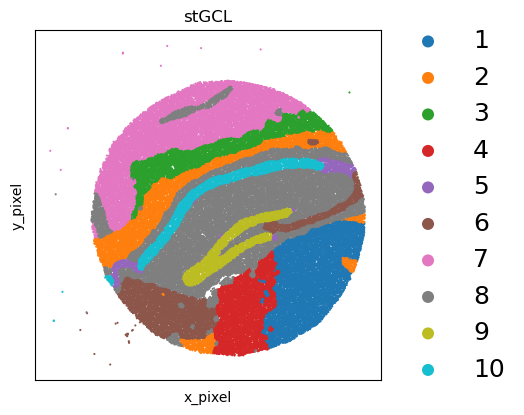

In [12]:
%matplotlib inline
ax = sc.pl.scatter(adata, alpha=1, x="x_pixel", y="y_pixel", color='stGCL', legend_fontsize=18, show=False,title="stGCL",
                   size=500000 / adata.shape[0])
ax.set_aspect('equal', 'box')
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel('x_pixel')
plt.ylabel('y_pixel')